In [ ]:
# Data generation
import json
import time
import math
import random
import statsmodels
import pandas as pd
from datetime import datetime

# Settable parameters
timestamps_onemin = 4 * 7 * 24 * 60
timestamp_start_s = 1571608800
starting_hour = 8
end_hour = 20
room_capacity = 25
lesson_duration_hours = 2
lesson_duration_min = lesson_duration_hours * 60
arrival_and_exit_delay_min = 8
falloff_border = lesson_duration_min - arrival_and_exit_delay_min
arrival_and_exit_coef_min = room_capacity / arrival_and_exit_delay_min

# Function that models count of students in the room based on time of the day
def count_in_room(cur_val, coef, delay_val, capacity, falloff_val):
    cnt = capacity
    lb = -math.floor(0.1 * capacity)
    ub = math.ceil(0.1 * capacity)
    
    if cur_val <= delay_val:
        cnt = min(max(math.floor(coef * cur_val) + random.randrange(lb, ub, 1), 0), capacity)
    elif cur_val >= falloff_val:
        cnt = max(min(capacity, math.floor(capacity - coef * (cur_val - falloff_val)) + random.randrange(lb, ub, 1)), 0)
    # TODO: you can also model students going in and out of the room during the lesson
    
    return cnt

generated_ts = pd.DataFrame(columns = ['t', 'count'])

# Generating simulated students' count data - 
for i in range(timestamps_onemin):
    cur_timestamp_s = timestamp_start_s + i * 60
    cur_date = datetime.fromtimestamp(cur_timestamp_s)
    cur_wd = cur_date.weekday()
    cur_hour = cur_date.hour
    cur_min = cur_date.minute
    
    cnt_in_room = 0
    if (cur_wd < 5) & (cur_hour >= starting_hour) & (cur_hour <= end_hour):
        lessons_cur_min = (cur_hour * 60 + cur_min) % lesson_duration_min 
        cnt_in_room = count_in_room(lessons_cur_min, arrival_and_exit_coef_min, arrival_and_exit_delay_min, room_capacity, falloff_border)
    
    df_row = pd.DataFrame([[cur_date, cnt_in_room]], columns=['t', 'count'])
    generated_ts = generated_ts.append(df_row)
        
    # TODO: uncomment to check what is being generated    
    # print("%s : %d" % (cur_date , cnt_in_room))

generated_ts.index = generated_ts.t
print(generated_ts)

In [37]:
# Forecasting models derivation - on the example of SARIMAX
# References:
# http://www.statsmodels.org/dev/tsa.html
# http://www.statsmodels.org/dev/statespace.html
# http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html
from scipy.stats import norm
import statsmodels.api as sm

# TODO: figure out the correct frequency for your data; e.g. 'b' for business days, None by default.
# generated_ts.index.freq = 'b'
# TODO: figure out correct coefficients for your data.
mod = sm.tsa.statespace.SARIMAX(generated_ts['count'].astype(float), trend='c', order=(1,1,(1,0,0,1)))
res = mod.fit(disp=False)
print(res.summary())

/home/remit/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             Statespace Model Results                            
Dep. Variable:                     count   No. Observations:                40320
Model:             SARIMAX(1, 1, (1, 4))   Log Likelihood              -53104.465
Date:                   Fri, 22 Nov 2019   AIC                         106218.930
Time:                           17:01:34   BIC                         106261.953
Sample:                                0   HQIC                        106232.543
                                 - 40320                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.522e-06      0.000     -0.014      0.989      -0.000       0.000
ar.L1          0.9545      0.003    302.026      0.000       0.948       0.961
ma.L1         -0.7662      0

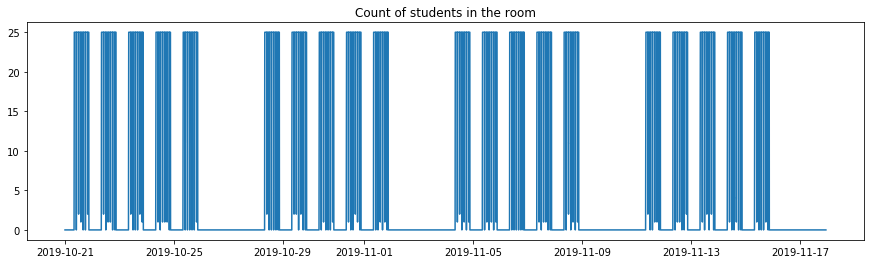

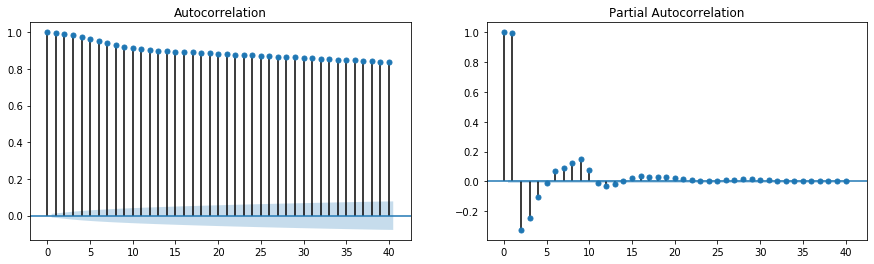

In [47]:
# Visualization and analysis
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 1, figsize=(15,4))

# Visualizing the original data
axes.plot(generated_ts.index._mpl_repr(), generated_ts['count'], '-')
axes.set(title = 'Count of students in the room')

# Visualizing ACF and PACF of time series
fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig = sm.graphics.tsa.plot_acf(generated_ts.iloc[1:]['count'].astype('float'), lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(generated_ts.iloc[1:]['count'].astype('float'), lags=40, ax=axes[1])

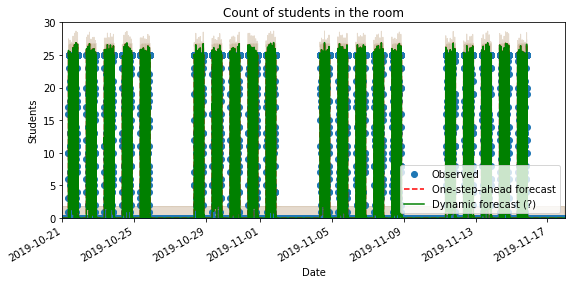

In [64]:
# Predictions

# In-sample one-step-ahead predictions
predict = res.get_prediction()
predict_ci = predict.conf_int()

# Dynamic predictions
dyn_pred_start = generated_ts.index[0]
predict_dy = res.get_prediction(start = dyn_pred_start)
predict_dy_ci = predict_dy.conf_int()

# Graph
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title = 'Count of students in the room', xlabel='Date', ylabel='Students')
ax.set_ylim([0, 30])

# Plot data points
generated_ts.loc[dyn_pred_start:, 'count'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.loc[dyn_pred_start:].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.loc[dyn_pred_start:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
predict_dy.predicted_mean.loc[dyn_pred_start:].plot(ax=ax, style='g', label='Dynamic forecast (?)')
ci = predict_dy_ci.loc[dyn_pred_start:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')